In [31]:
import imp
import os
import cv2
import pdb
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
# from torch.nn.functional import InterpolationMode
import torchvision.models as models

In [2]:
gloss_df_path = "data_validation/processed_gloss.csv"
gloss_df = pd.read_csv(gloss_df_path)
gloss_df.dropna(inplace=True)

In [3]:
gloss_df.head()

,gloss,glossStart,glossEnd,fileName,sentenceID
0,MƏN,9.0,24.0,2022-07-18 16-41-51.mp4,70
1,EV,29.0,41.0,2022-07-18 16-41-51.mp4,70
2,YANMAQ,46.0,102.0,2022-07-18 16-41-51.mp4,70
3,EV,30.0,41.0,2022-07-20 14-09-03.mp4,70
4,YANMAQ,44.0,74.0,2022-07-20 14-09-03.mp4,70


In [4]:
def img_resize(img_path, dims=(256, 256)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, dsize=dims)

    return img

In [5]:
gloss_df[pd.isnull(gloss_df['glossStart'])]

,gloss,glossStart,glossEnd,fileName,sentenceID


In [6]:
num_classes = len(gloss_df.gloss.unique())
num_classes

234

In [7]:
from torchvision.models import resnet50, ResNet50_Weights

In [8]:
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)

In [9]:
for name, para in model.named_parameters():
    print('{}: {}'.format(name, para.shape))

conv1.weight: torch.Size([64, 3, 7, 7])
bn1.weight: torch.Size([64])
bn1.bias: torch.Size([64])
layer1.0.conv1.weight: torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight: torch.Size([64])
layer1.0.bn1.bias: torch.Size([64])
layer1.0.conv2.weight: torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight: torch.Size([64])
layer1.0.bn2.bias: torch.Size([64])
layer1.0.conv3.weight: torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight: torch.Size([256])
layer1.0.bn3.bias: torch.Size([256])
layer1.0.downsample.0.weight: torch.Size([256, 64, 1, 1])
layer1.0.downsample.1.weight: torch.Size([256])
layer1.0.downsample.1.bias: torch.Size([256])
layer1.1.conv1.weight: torch.Size([64, 256, 1, 1])
layer1.1.bn1.weight: torch.Size([64])
layer1.1.bn1.bias: torch.Size([64])
layer1.1.conv2.weight: torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight: torch.Size([64])
layer1.1.bn2.bias: torch.Size([64])
layer1.1.conv3.weight: torch.Size([256, 64, 1, 1])
layer1.1.bn3.weight: torch.Size([256])
layer1.1.bn3.bias: torch.Size([256])
l

In [10]:
preprocess = weights.transforms()

In [11]:
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [12]:
import cv2
import matplotlib.pyplot as plt
import PIL

In [28]:
froom typing import Optional, Tuple

In [32]:
class ImageClassification(nn.Module):
    def __init__(
        self,
        *,
        crop_size: int,
        resize_size: int = 256,
        mean: Tuple[float, ...] = (0.485, 0.456, 0.406),
        std: Tuple[float, ...] = (0.229, 0.224, 0.225),
        # interpolation: InterpolationMode = InterpolationMode.BILINEAR,
    ) -> None:
        super().__init__()
        self.crop_size = [crop_size]
        self.resize_size = [resize_size]
        self.mean = list(mean)
        self.std = list(std)
        # self.interpolation = interpolation

    def forward(self, img: Tensor) -> Tensor:
        img = F.resize(img, self.resize_size)
        img = F.center_crop(img, self.crop_size)
        if not isinstance(img, Tensor):
            img = F.pil_to_tensor(img)
        img = F.convert_image_dtype(img, torch.float)
        # img = F.normalize(img, mean=self.mean, std=self.std)
        return img

    def __repr__(self) -> str:
        format_string = self.__class__.__name__ + "("
        format_string += f"\n    crop_size={self.crop_size}"
        format_string += f"\n    resize_size={self.resize_size}"
        format_string += f"\n    mean={self.mean}"
        format_string += f"\n    std={self.std}"
        # format_string += f"\n    interpolation={self.interpolation}"
        format_string += "\n)"
        return format_string

    def describe(self) -> str:
        return (
            "Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. "
            f"The images are resized to ``resize_size={self.resize_size}`` using ``interpolation={self.interpolation}``, "
            f"followed by a central crop of ``crop_size={self.crop_size}``. Finally the values are first rescaled to "
            f"``[0.0, 1.0]`` and then normalized using ``mean={self.mean}`` and ``std={self.std}``."
        )


In [36]:
from functools import partial
transforms=partial(ImageClassification, crop_size=224, resize_size=232)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


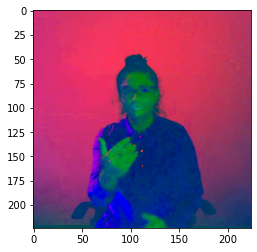

In [44]:
file_path = "../data/cam2/1/2022-05-26 11-15-10.mp4"

cap = cv2.VideoCapture(file_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 50)
res, img = cap.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
img = PIL.Image.fromarray(img)
img = preprocess(img)
plt.imshow(img.permute(1, 2, 0))

In [14]:
from modules.temp_conv import TemporalConv

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [17]:
model.eval().to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 